In [9]:
import torch
import torch.nn.functional as F
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

Sample Graph data 

In [3]:
# Define the Graph data structure
edge_index = torch.tensor([[0, 1, 0],  # From nodes (A -> B, B -> C, A -> C)
                                [1, 2, 2]],     # To nodes
                          dtype=torch.long)
node_labels = ["A", "B", "C"]

In [4]:
graph_data = Data(edge_index=edge_index)

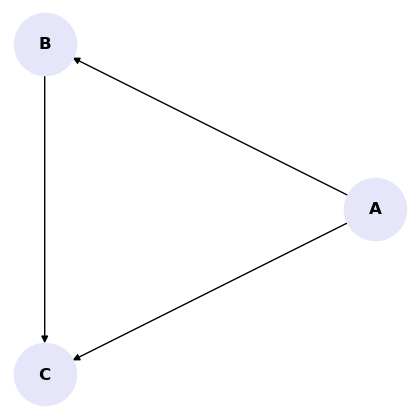

In [8]:
# Convert to NetworkX for visualization
G = nx.DiGraph()
G.add_edges_from(edge_index.t().tolist())

plt.figure(figsize=(4, 4))
pos = nx.circular_layout(G)  # Automatically adjust nodes location
nx.draw(G, pos,
        with_labels=True, labels={i: node_labels[i] for i in range(len(node_labels))},
        node_color='lavender',
        edge_color='black',
        node_size=2000,
        font_size=12, font_weight='bold', arrows=True)
plt.show()

	
Simple GCN with dummy data (Node classification)

In [45]:
# Dummy dataset
num_nodes = 5
num_features = 3
num_classes = 2

x = torch.randn(num_nodes, num_features) # random node features
edge_index = torch.tensor([[0, 1, 1, 2, 3, 4], [1, 2, 3, 4, 0, 1]], dtype=torch.long) # random edges 
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long) # random labels

data = Data(x=x, edge_index=edge_index, y=y)

In [46]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [47]:
model = SimpleGNN(num_features=num_features, hidden_channels=4,num_classes=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6358810067176819
Epoch 10, Loss: 0.6189125776290894
Epoch 20, Loss: 0.6069061160087585
Epoch 30, Loss: 0.6001120209693909
Epoch 40, Loss: 0.594841718673706
Epoch 50, Loss: 0.590779185295105
Epoch 60, Loss: 0.5888096690177917
Epoch 70, Loss: 0.5870092511177063
Epoch 80, Loss: 0.5848332643508911
Epoch 90, Loss: 0.5823889374732971


In [48]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
print(f'Predictions: {pred}')
print(f'Ground Truth: {data.y}')

Predictions: tensor([1, 0, 0, 1, 0])
Ground Truth: tensor([0, 1, 0, 1, 0])


Classification problem: Male or Female

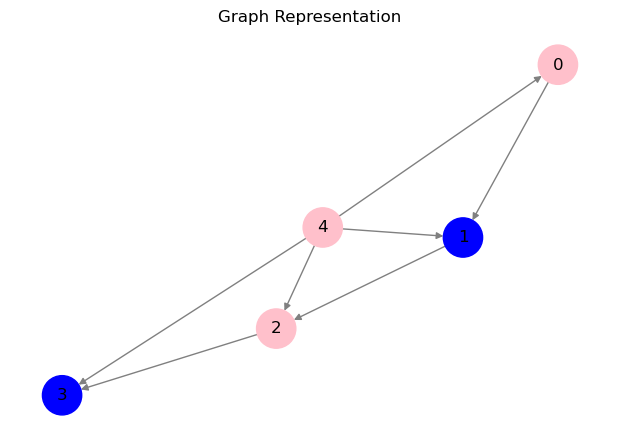

In [44]:
G = nx.DiGraph() # Directed Graph 

# Nodes with gender labels (0: Male, 1: Female)
nodes = {
    0: {"gender": 1}, 
    1: {"gender": 0}, 
    2: {"gender": 1}, 
    3: {"gender": 0},
    4: {"gender": 1}
}

G.add_nodes_from(nodes.keys())

# Edges to represent relationships/friends
edges = [[0, 1], [1, 2], [2, 3], [4, 0], [4, 1], [4, 2], [4, 3]]
G.add_edges_from(edges)

# Colors for visualization (blue - male, pink - female)
node_colors = ['blue' if nodes[n]['gender'] == 0 else 'pink' for n in G.nodes]

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='gray', node_size=800)
plt.title("Graph Representation")
# plt.savefig("gender.png")
plt.show()

In [39]:
edges = [[0, 1], [1, 2], [2, 3], [4, 0], [4, 1], [4, 2], [4, 3]]
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()


x = torch.tensor([[25, 180],
                  [23, 165],
                  [30, 175],
                  [28, 160],
                  [22, 170]], dtype=torch.float)
y = torch.tensor([1, 0, 1, 0, 1], dtype=torch.long)

# Create train/test mask
num_nodes = x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_indices = torch.randperm(num_nodes)[:int(0.6 * num_nodes)]
test_indices = torch.tensor([i for i in range(num_nodes) if i not in train_indices])

train_mask[train_indices] = True
test_mask[test_indices] = True

data = Data(x=x, edge_index=edges, y=y, train_mask=train_mask, test_mask=test_mask)

In [40]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [41]:
model = GCN(input_dim=2, hidden_dim=4, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

def train(model, data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask]) 
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
            
train(model, data)

Epoch 0, Loss: 16.8885
Epoch 10, Loss: 3.9847
Epoch 20, Loss: 0.8649
Epoch 30, Loss: 1.3133
Epoch 40, Loss: 0.9797
Epoch 50, Loss: 0.7807
Epoch 60, Loss: 0.7909
Epoch 70, Loss: 0.7713
Epoch 80, Loss: 0.7564
Epoch 90, Loss: 0.7513


In [43]:
def test(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data).argmax(dim=1)
        accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f'Accuracy: {accuracy:.4f}')
        print(f"Prediction: {pred}")
        print(f"Target: {data.y}")
        
test(model, data)

Accuracy: 0.5000
Prediction: tensor([1, 1, 1, 1, 1])
Target: tensor([1, 0, 1, 0, 1])
